In [385]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [386]:
# Import the database
guesthouse = pd.read_excel('Guesthouse..xls')
guesthouse.head(5)

,Name,Number of guests,Nacionality,Gender,Price,Price per night,Number of nights,Check-in,Check out,Year,Month,Months,Review,Rooms
0,Artur,1,Brazil,M,73.0,24.333333,3,2017-04-12,2017-04-15 00:00:00,2017,4,Apr,1,Blue Room
1,Jon,1,South korea,M,73.0,24.333333,3,2017-02-11,2017-02-14 00:00:00,2017,2,Feb,1,Blue Room
2,Kleber,1,Brazil,M,270.0,27.000000,10,2017-02-20,2017-03-02 00:00:00,2017,2,Feb,1,Blue Room
3,Judith,2,Germany,F,73.0,36.500000,2,2017-07-03,2017-07-05 00:00:00,2017,7,Jul,1,Double Room
4,Elisa Yuan,2,UK,F,44.0,44.000000,1,2017-04-08,2017-04-09 00:00:00,2017,4,Apr,0,Double Room


In [387]:
guesthouse.describe()

,Number of guests,Price,Price per night,Number of nights,Year,Month,Review
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,2.203636,139.056655,51.180956,2.876364,2017.440000,6.505455,0.338182
std,1.296537,162.132529,29.498074,2.509687,0.497292,3.112690,0.473953
min,1.000000,24.080000,12.500000,1.000000,2017.000000,1.000000,0.000000
25%,1.000000,60.195000,30.340000,1.000000,2017.000000,4.000000,0.000000
50%,2.000000,89.570000,40.770000,2.000000,2017.000000,7.000000,0.000000
75%,3.000000,151.105000,64.318333,3.000000,2018.000000,9.000000,1.000000
max,5.000000,1597.000000,153.024000,24.000000,2018.000000,12.000000,1.000000


In [388]:
guesthouse.info()
# No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name              275 non-null    object        
 1   Number of guests  275 non-null    int64         
 2   Nacionality       275 non-null    object        
 3   Gender            275 non-null    object        
 4   Price             275 non-null    float64       
 5   Price per night   275 non-null    float64       
 6   Number of nights  275 non-null    int64         
 7   Check-in          275 non-null    datetime64[ns]
 8   Check out         275 non-null    object        
 9   Year              275 non-null    int64         
 10  Month             275 non-null    int64         
 11  Months            275 non-null    object        
 12  Review            275 non-null    int64         
 13  Rooms             275 non-null    object        
dtypes: datetime64[ns](1), floa

In [389]:
# Let's check how many unique nacionalities?
guesthouse['Nacionality'].nunique()

41

In [390]:
guesthouse['Price'].describe()

count     275.000000
mean      139.056655
std       162.132529
min        24.080000
25%        60.195000
50%        89.570000
75%       151.105000
max      1597.000000
Name: Price, dtype: float64

In [409]:
# Remove the outlier rows with price > 500€
clean_guesthouse = guesthouse.drop([5, 9, 49, 113, 145, 158, 184, 226, 232, 235, 240, 153, 176, 241])

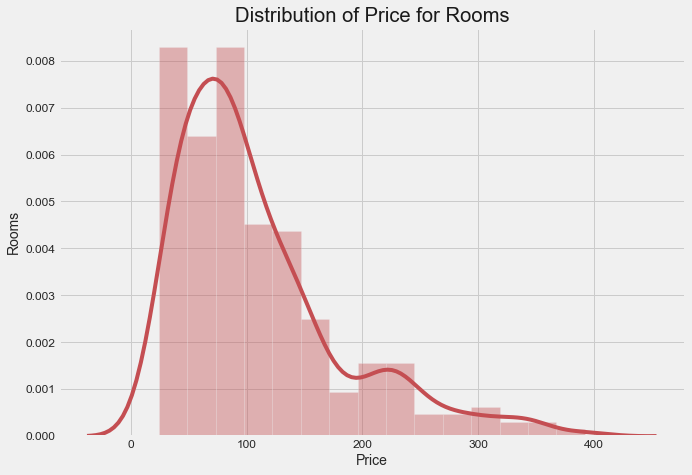

In [410]:
plt.figure(figsize=(10,7))
sns.distplot(clean_guesthouse.Price,color='r')
plt.xlabel("Price")
plt.ylabel('Rooms')
plt.title("Distribution of Price for Rooms")
plt.show()

Shapiro Test (for checking Normality):
    
H0 (Null Hypothesis) : Distribution is normal

H1 (Alternative Hypothesis): Distribution is not normal

In [393]:
import scipy.stats as st
st.shapiro(clean_guesthouse.Price)

ShapiroResult(statistic=0.8310526609420776, pvalue=2.8467707978121126e-16)

Since p value is less than alpha (5% - assumed), the null hypothesis is rejected. Therefore, the distribution is not normal (as could be seen from the Distribution Plot above). Since the distribution is not normal, theoretically only non-parametric tests can be performed on the data.

Price vs Room Type

In [394]:
clean_guesthouse.Rooms.unique()

array(['Blue Room', 'Double Room', 'Package 1', 'Package 3', 'Package 2',
       'Brown Room', 'Orange Room'], dtype=object)

In [395]:
# Now they all have similar population
pvt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Blue Room']
pvt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Brown Room']
pvt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Orange Room']
dbl = clean_guesthouse[clean_guesthouse['Rooms'] == 'Double Room']
apt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Package 1']
apt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Package 2']
apt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Package 3']

Levene Test (for testing of variance)

H0 (null hypothesis): variance(Single Rooms) = variance(Double Room) = variance(Packages)

H1 (alternative hypothesis): variance(Single Rooms) != variance(Double Room) != variance(Packages)

In [396]:
st.levene(pvt.Price, dbl.Price, apt.Price)

LeveneResult(statistic=15.214352053200349, pvalue=9.636563483406991e-07)

Since p value is approximately zero (and thus less than 5% assumed), we reject H0. Therefore, the variance of the price for different categories of rooms is not the same. This can be confirmed by observing the boxplot below.

In [468]:
guesthouse_original = pd.read_excel('Guesthouse._original.xls')
guesthouse_original.head(5)

,Name,Number of guests,Sum number of guests,Nacionality,Gender,Price,Price per night,Number of nights,Check-in,Check out,Year,Month,Months,Review,Rooms,Type of room,Ranking
0,Artur,1,1,Brazil,M,73.0,24.333333,3,2017-04-12,2017-04-15 00:00:00,2017,4,Apr,1,Blue Room,Single Room,3.0
1,Jon,1,2,South korea,M,73.0,24.333333,3,2017-02-11,2017-02-14 00:00:00,2017,2,Feb,1,Blue Room,Single Room,8.0
2,Kleber,1,3,Brazil,M,270.0,27.000000,10,2017-02-20,2017-03-02 00:00:00,2017,2,Feb,1,Blue Room,Single Room,3.0
3,Judith,2,5,Germany,F,73.0,36.500000,2,2017-07-03,2017-07-05 00:00:00,2017,7,Jul,1,Double Room,Double Room,2.0
4,Elisa Yuan,2,7,UK,F,44.0,44.000000,1,2017-04-08,2017-04-09 00:00:00,2017,4,Apr,0,Double Room,Double Room,4.0


In [476]:
# Remove the outlier rows with price > 500€
guesthouse_original_r = guesthouse_original.drop([5, 9, 49, 113, 145, 158, 184, 226, 232, 235, 240, 153, 176, 242])

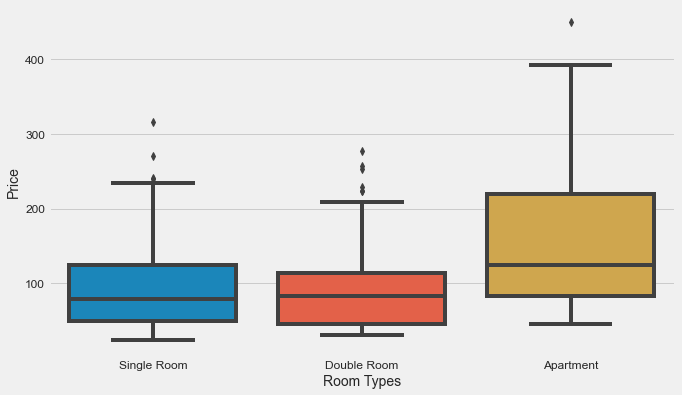

In [477]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Price',x='Type of room',data=guesthouse_original_r)
plt.xlabel('Room Types')
plt.show()

Kruskal Wallis Test

H0 (null hypothesis): mean_price(Single Rooms) = mean_price(Double Room) = mean_price(Packages)

H1 (alternate hypothesis): mean_price(Singles Rooms) != mean_price(Dpuble Room) != mean_price(Packages)

In [398]:
st.kruskal(pvt.Price,dbl.Price,apt.Price)

KruskalResult(statistic=50.79366766204224, pvalue=9.338888911199704e-12)

In the above test result, p value < 0.05. Therefore, null hypothesis is rejected. This implies that the mean price across different types of rooms is not the same. We can confirm that from the barplot of the mean prices shown below.

In [399]:
ind = ['Single Rooms','Packages','Double Room']
x = pd.DataFrame([pvt.Price.mean(),apt.Price.mean(),dbl.Price.mean()], index=ind)
x

,0
Single Rooms,70.962143
Packages,209.076154
Double Room,93.105800


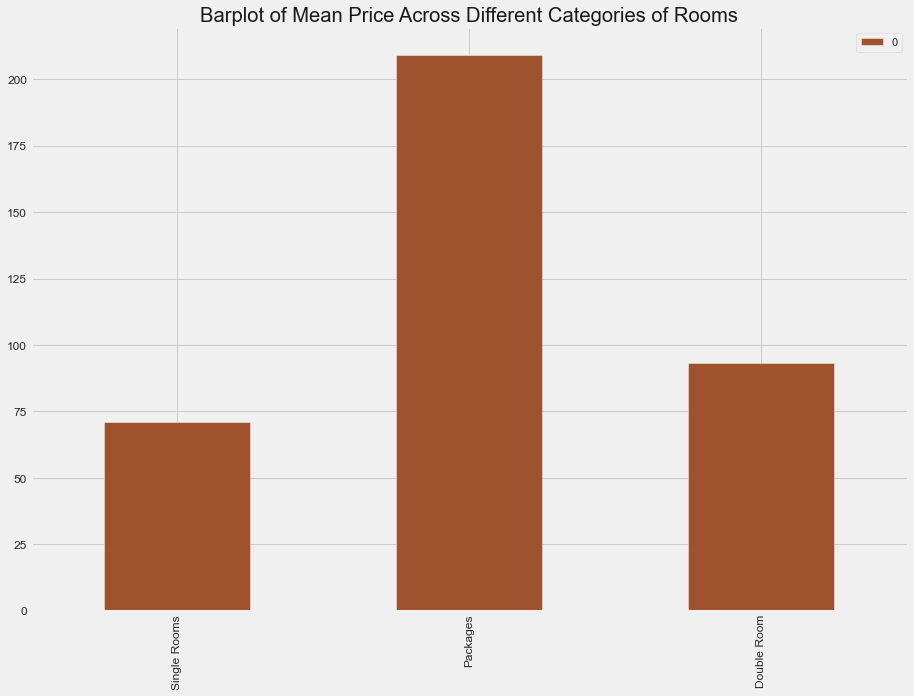

In [400]:
x.plot.bar(color='sienna')
plt.title("Barplot of Mean Price Across Different Categories of Rooms")
plt.show()

Conclusion: There is association between Price and Room Type. The price is dependent on the type of room that a person chooses since the mean price across all types is not equal.
Since the assumptions of Normality and Variance are violated, theoretically parametric tests cannot be performed but still it can be checked if the parametric test (one way ANOVA) gives the same result in this case.

One Way ANOVA

H0 (null hypothesis): mean_price(Silngle Rooms) = mean_price(Double Room) = mean_price(Packages)

H1 (alternate hypothesis): mean_price(Single Rooms) != mean_price(Double Room) != mean_price(Packages)

In [401]:
st.f_oneway(pvt.Price,dbl.Price,apt.Price)

F_onewayResult(statistic=42.279018345848385, pvalue=2.742019836764088e-15)

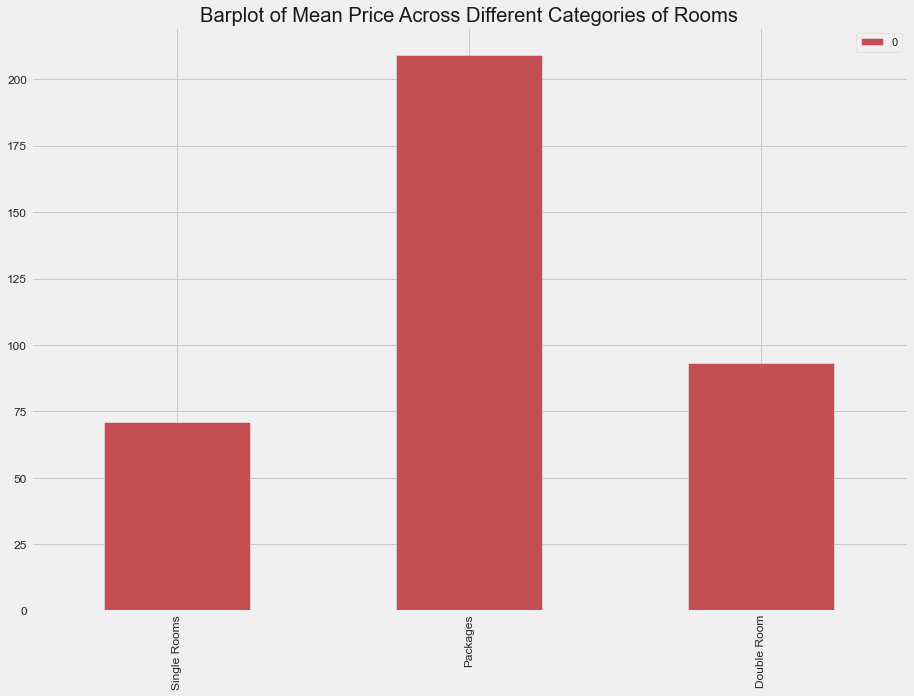

In [402]:
x.plot.bar(color='r')
plt.title("Barplot of Mean Price Across Different Categories of Rooms")
plt.show()

Hypothesis Test:

H0 (Null Hypothesis): Guests stay in Lisbon on average =< 2 nights

H1 (Alternate Hypothesis): Guests stay in Lisbonon average >2 nights

In [403]:
guest_sample = guesthouse.drop(['Name', 'Number of guests', 'Year', 'Months', 'Month', 'Nacionality', 'Gender', 'Price', 'Price per night' , 'Review', 'Rooms', 'Check-in', 'Check out'], axis=1)
guest_sample

,Number of nights
0,3
1,3
2,10
3,2
4,1
...,...
270,2
271,2
272,3
273,2


In [404]:
mean = guest_sample.mean()
std = guest_sample.std(ddof=1)
display(mean)
display(std)

Number of nights    2.876364
dtype: float64

Number of nights    2.509687
dtype: float64

In [405]:
stat = (mean-2)/(std/np.sqrt(275))
stat
# H0 mu <= 2

Number of nights    5.790702
dtype: float64

In [406]:
# p-value 2-tailed
display(st.t.sf(abs(stat),189-1)*2)
# p-value 1-tailed
display(st.t.sf(abs(stat),189-1))

array([2.89765032e-08])

array([1.44882516e-08])

In [384]:
st.ttest_1samp(guest_sample, 2)

Ttest_1sampResult(statistic=array([5.79070182]), pvalue=array([1.91719106e-08]))

In the above test result, p value < alpha (0.05). Therefore, null hypothesis is rejected. This implies that the average that a guest stays in Lisbon is => 3 nights

Before going to the next statistical model let's analyse the database for a moment and check some curiosities

A heatmap can be used to check the correlation between continuous variables in the dataset.

In [105]:
guesthouse.corr()

,Number of guests,Price,Price per night,Number of nights,Year,Month,Review
Number of guests,1.000000,0.490452,0.893762,-0.016910,0.019019,-0.011128,0.000367
Price,0.490452,1.000000,0.460526,0.715281,0.049580,-0.005065,0.073998
Price per night,0.893762,0.460526,1.000000,-0.110605,-0.028138,0.038354,0.024732
Number of nights,-0.016910,0.715281,-0.110605,1.000000,-0.003041,-0.023740,0.130396
Year,0.019019,0.049580,-0.028138,-0.003041,1.000000,-0.585105,-0.587179
Month,-0.011128,-0.005065,0.038354,-0.023740,-0.585105,1.000000,0.227579
Review,0.000367,0.073998,0.024732,0.130396,-0.587179,0.227579,1.000000


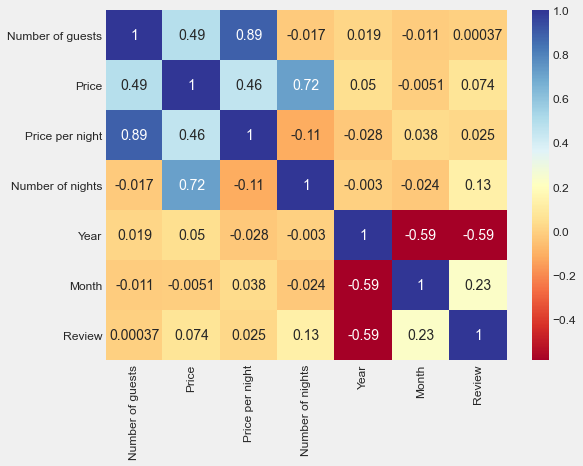

In [296]:
plt.figure(figsize=(8,6))
sns.heatmap(guesthouse.corr(),annot=True,cmap="RdYlBu")
plt.show()

Scatter Plot

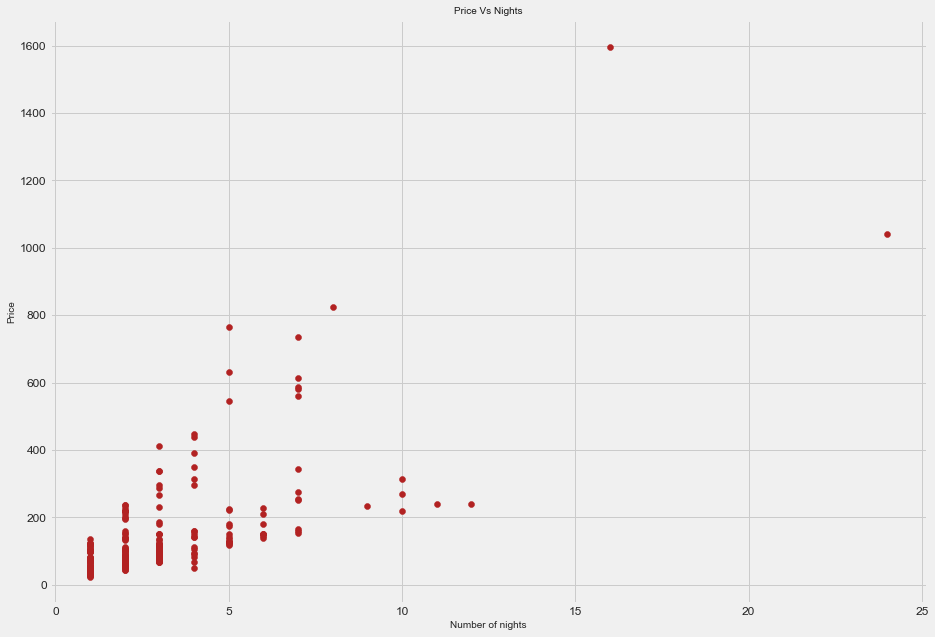

In [314]:
plt.scatter(guesthouse['Number of nights'], guesthouse['Price'], color='firebrick')
plt.title('Price Vs Nights', fontsize=10)
plt.xlabel('Number of nights', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.grid(True)
plt.show()

Chart Bart

Text(0.5, 1.0, 'TOP 15 GUEST NACIONALITIES.')

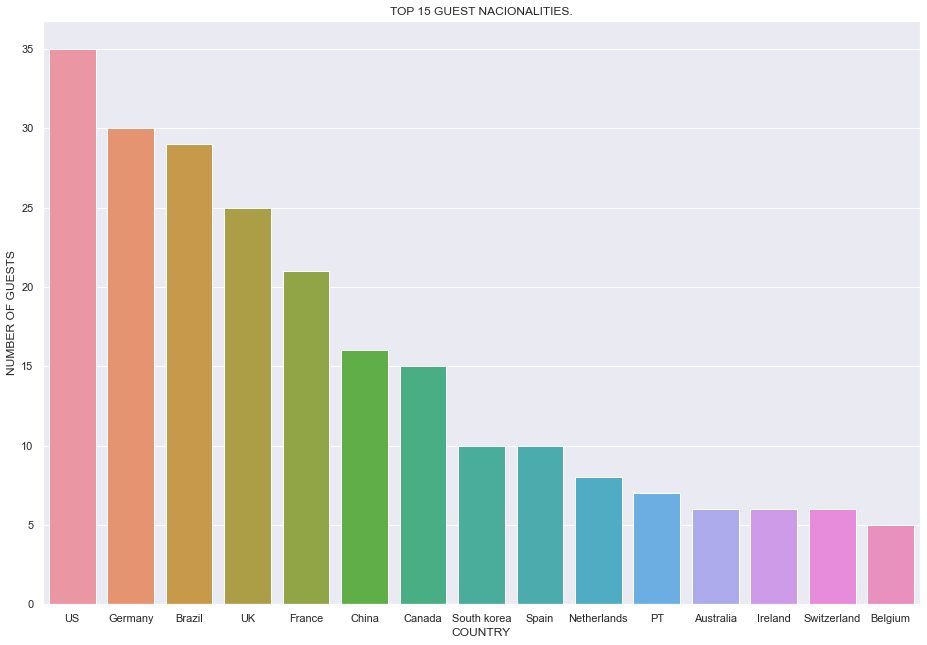

In [157]:
fig_1 = pd.DataFrame(guesthouse.Nacionality.value_counts(dropna=False).head(15))
fig_1
sns.set(rc={'figure.figsize':(14,10)})
ax = sns.barplot(fig_1.index,fig_1['Nacionality'])
plt.ylabel('NUMBER OF GUESTS')
plt.xlabel('COUNTRY')
plt.title("TOP 15 GUEST NACIONALITIES.")

Pie Chart

Remember that we only have the gender from the guest that performed the reservation so we are assuming that all the guests that accompanied them were from the same gender which is highly unlikely especially for the Double Room so the information from this pie chart wil never be precise.

Text(0.5, 1.0, 'Percentage of Male Vs Female guests.')

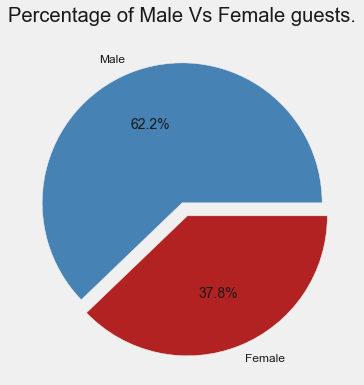

In [333]:
plt.figure(figsize=(8,6))
plt.pie(x=guesthouse['Gender'].value_counts(),autopct='%1.1f%%',explode=(0,0.1), colors = ['steelblue', 'firebrick'], labels=['Male','Female'])
plt.title('Percentage of Male Vs Female guests.')

In [69]:
# Get guests count for each room
guests_count = guesthouse.groupby('Rooms').count()

# Reset index
guests_count = guests_count.reset_index()


# Create new dataframe for Rooms and guest count
guests_count = guests_count[["Rooms", "Number of guests"]]

# Rename columns
guests_count.rename(columns={"Number of guests": "Guests count"}, inplace=True)

Text(0, 0.5, 'Number of guests')

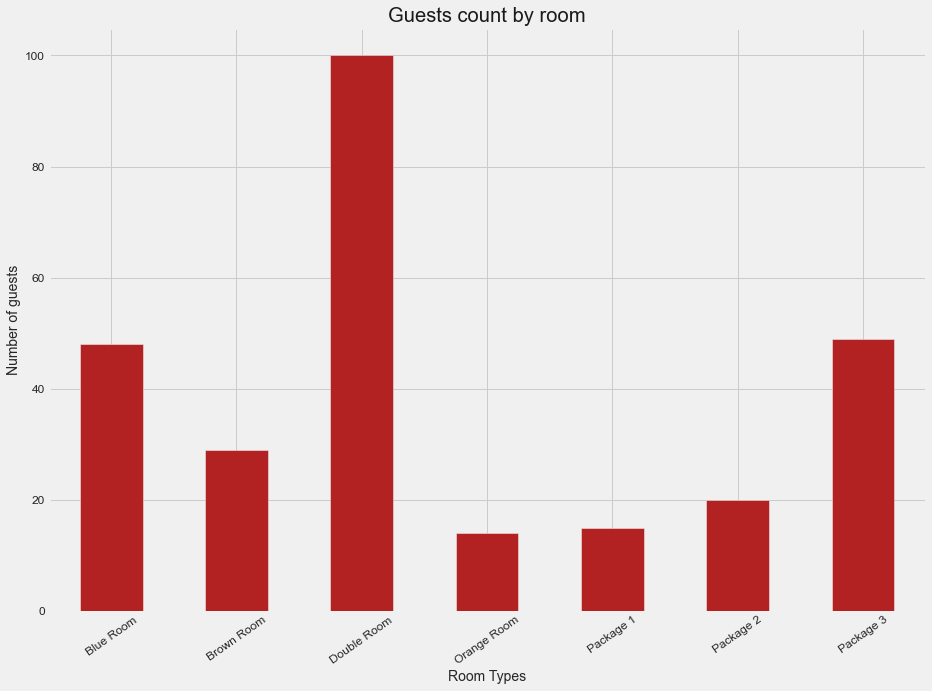

In [313]:
# Create bar chart for number of guests count by room
room_plot = guests_count.plot.bar(x="Rooms", y="Guests count", rot=90, legend=None, color="firebrick", zorder=3)
plt.grid(which="major", axis="y", zorder=0)
plt.xticks(rotation=35)
plt.title("Guests count by room")
plt.xlabel("Room Types")
plt.ylabel("Number of guests")

In [134]:
# Obtain the mean and standard deviation (STD)
price_mean = guesthouse.groupby(["Rooms"]).mean()["Price per night"]
display(price_mean)

price_std = guesthouse.groupby(["Rooms"]).std()["Price per night"]
display(price_std)

Rooms
Blue Room       28.831838
Brown Room      27.696469
Double Room     41.593619
Orange Room     30.297381
Package 1       61.202000
Package 2       58.607702
Package 3      106.406687
Name: Price per night, dtype: float64

Rooms
Blue Room       7.866793
Brown Room      4.842596
Double Room     8.455497
Orange Room     4.641701
Package 1      16.456673
Package 2      16.796440
Package 3      15.153235
Name: Price per night, dtype: float64

Text(0, 0.5, 'Price')

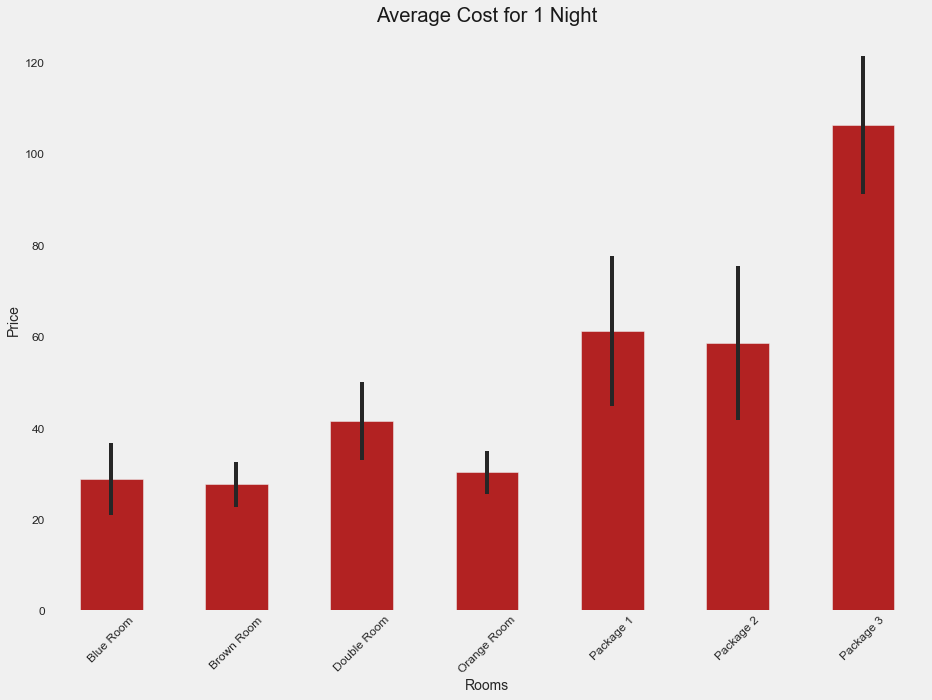

In [312]:
# Create new dataframe for mean values
mean_df = pd.DataFrame({"Rooms":price_mean.index, "Price per night":price_mean.values})
mean_df = mean_df.set_index("Rooms")
mean_df

# Create bar chart with y error bar 
mean_df.plot(kind="bar", yerr=price_std.values, color="firebrick", legend=None)
plt.xticks(rotation=45)
plt.grid()
plt.title("Average Cost for 1 Night")
plt.ylabel("Price")